<h1><center> Emotions in context (Emotic) </center></h1>
<center> Baseline model</center>

# I. Prepare places pretrained model

In [28]:
import os
import requests
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.metrics.pairwise import cosine_similarity


Purpose: Downloads and prepares the pre-trained Places365 ResNet18 model for context feature extraction.

Essential for initializing the context feature extractor.

Summary: This section downloads a pre-trained ResNet18 model on the Places365 dataset, which is used to extract contextual features from images.

In [2]:
# Create a directory to save the model
os.makedirs("places", exist_ok=True)

# URL of the ResNet model
model_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
model_path = "./places/resnet18_places365.pth.tar"

# Download the model if not already downloaded
if not os.path.exists(model_path):
    print("Downloading ResNet model...")
    response = requests.get(model_url, stream=True)
    with open(model_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete.")
else:
    print("Model already exists.")


Model already exists.


In [3]:
# Saving the model weights to use ahead in the notebook

# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


# II. Emotic classes

## Emotic Model 

Purpose: Defines a neural network model that processes image and text inputs separately to predict emotions without fusion.

Initialization: Sets up two parallel pathways for image and text, each with their own linear, batch normalization, and activation layers.

Image Pathway: Transforms body features into a 256-dimensional embedding space through linear projection, normalization, and activation.

Text Pathway: Transforms context features into a separate 256-dimensional embedding space through similar operations.

Output Layers: Creates separate prediction heads for each modality (4 total) - categorical emotions and continuous dimensions for both image and text.

Forward Pass: Processes inputs through their respective pathways and returns separate predictions for each modality along with the embeddings.

Summary:  A dual-pathway neural network that maintains separate embedding spaces for image and text modalities to enable comparative analysis of their individual contributions to emotion recognition.

In [13]:
class EmoticSeparateEmbeddings(nn.Module):
    ''' Emotic Model with separate embedding spaces for image and text '''
    def __init__(self, context_features, body_features, embedding_dim=256):
        super(EmoticSeparateEmbeddings, self).__init__()
        self.context_features = context_features
        self.body_features = body_features
        self.embedding_dim = embedding_dim
        
        # Image embedding pathway
        self.img_fc = nn.Linear(body_features, embedding_dim)
        self.img_bn = nn.BatchNorm1d(embedding_dim)
        self.img_relu = nn.ReLU()
        
        # Text embedding pathway
        self.text_fc = nn.Linear(context_features, embedding_dim)
        self.text_bn = nn.BatchNorm1d(embedding_dim)
        self.text_relu = nn.ReLU()
        
        # Output layers (directly from separate embeddings)
        self.fc_cat_img = nn.Linear(embedding_dim, 26)  # Image pathway output
        self.fc_cat_text = nn.Linear(embedding_dim, 26)  # Text pathway output
        self.fc_cont_img = nn.Linear(embedding_dim, 3)  # Image pathway output
        self.fc_cont_text = nn.Linear(embedding_dim, 3)  # Text pathway output

    def forward(self, x_context, x_body):
        # Process context features (text)
        context_features = x_context.view(-1, self.context_features)
        text_embedding = self.text_fc(context_features)
        text_embedding = self.text_bn(text_embedding)
        text_embedding = self.text_relu(text_embedding)
        
        # Process body features (image)
        body_features = x_body.view(-1, self.body_features)
        img_embedding = self.img_fc(body_features)
        img_embedding = self.img_bn(img_embedding)
        img_embedding = self.img_relu(img_embedding)
        
        # Separate predictions for each modality
        cat_out_img = self.fc_cat_img(img_embedding)
        cat_out_text = self.fc_cat_text(text_embedding)
        cont_out_img = self.fc_cont_img(img_embedding)
        cont_out_text = self.fc_cont_text(text_embedding)
        
        # Return 6 values: 4 outputs and 2 embeddings
        return cat_out_img, cat_out_text, cont_out_img, cont_out_text, img_embedding, text_embedding


## Emotic Dataset

Purpose: Custom dataset class for loading preprocessed EMOTIC data.

Needed for data loading.

Summary: This dataset class handles loading preprocessed context images, body images, categorical emotion labels, and continuous emotion dimensions from NumPy arrays, applying appropriate transformations and normalization

In [14]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, y_cat, y_cont, transform, context_norm, body_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.y_cat = y_cat 
    self.y_cont = y_cont
    self.transform = transform 
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std

  def __len__(self):
    return len(self.y_cat)
  
  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

Purpose: Custom loss functions for categorical and continuous emotion predictions.

Necessary for model training.

Summary: These loss functions are specialized for emotion recognition: DiscreteLoss handles multi-label classification with dynamic weighting, while ContinuousLoss_L2 and ContinuousLoss_SL1 handle regression for valence-arousal-dominance dimensions.

In [15]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)
    
  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum() 

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2 
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# III. Load preprocessed data

Purpose: Loads preprocessed EMOTIC data from NumPy arrays.

Update path to your data location.

Summary: This section loads preprocessed context images, body images, categorical labels, and continuous dimensions for training, validation, and testing sets, and creates mappings between emotion names and indices.

In [16]:
# Change data_src variable as per your drive
data_src = 'D:/Ruturaj/New folder (3)/Ruturaj/Smart Systems/MANAV Experiment/proj/data/emotic19/emotic_pre'

# Load training preprocessed data
train_context = np.load(os.path.join(data_src,'train_context_arr.npy'))
train_body = np.load(os.path.join(data_src,'train_body_arr.npy'))
train_cat = np.load(os.path.join(data_src,'train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'train_cont_arr.npy'))

# Load validation preprocessed data
val_context = np.load(os.path.join(data_src,'val_context_arr.npy'))
val_body = np.load(os.path.join(data_src,'val_body_arr.npy'))
val_cat = np.load(os.path.join(data_src,'val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'val_cont_arr.npy'))

# Load testing preprocessed data
test_context = np.load(os.path.join(data_src,'test_context_arr.npy'))
test_body = np.load(os.path.join(data_src,'test_body_arr.npy'))
test_cat = np.load(os.path.join(data_src,'test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
    cat2ind[emotion] = idx
    ind2cat[idx] = emotion

print('train ', 'context ', train_context.shape, 'body', train_body.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print('val ', 'context ', val_context.shape, 'body', val_body.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print('test ', 'context ', test_context.shape, 'body', test_body.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print('completed cell')

train  context  (23266, 224, 224, 3) body (23266, 128, 128, 3) cat  (23266, 26) cont (23266, 3)
val  context  (3315, 224, 224, 3) body (3315, 128, 128, 3) cat  (3315, 26) cont (3315, 3)
test  context  (7203, 224, 224, 3) body (7203, 128, 128, 3) cat  (7203, 26) cont (7203, 3)
completed cell


Purpose: Sets up data transformations, normalization, and data loaders.

Essential for proper data handling.

Summary: This section defines image transformations (including data augmentation for training), normalization parameters, and creates PyTorch DataLoader objects for efficient batch processing during training and evaluation.

In [17]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_cat, train_cont,
                                  train_transform, context_norm, body_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_cat, val_cont,
                                test_transform, context_norm, body_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_cat, test_cont,
                                 test_transform, context_norm, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print('completed cell')

train loader  894 val loader  128 test 278
completed cell


# IV. Prepare emotic model

Purpose: Initializes and prepares the feature extraction models and the emotion recognition model.

Essential for model setup.

Summary: This section loads the pre-trained Places365 model for context features, initializes a ResNet18 for body features, and creates the EmoticSeparateEmbeddings model with separate embedding spaces for each modality.

In [18]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(pretrained=True)

# Create the new model with separate embeddings
emotic_model = EmoticSeparateEmbeddings(
    list(model_context.children())[-1].in_features, 
    list(model_body.children())[-1].in_features,
    embedding_dim=256
)

model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

# print (summary(model_context, (3,224,224), device="cpu"))
# print (summary(model_body, (3,128,128), device="cpu"))

print ('completed cell')

completed cell


## Prepare optimizer

Purpose: Configures which model parameters to train and sets up optimization.

Necessary for training.

Summary: This section freezes the pre-trained feature extractors (context and body models) while making the fusion model (emotic_model) trainable. It also initializes the Adam optimizer, learning rate scheduler, and loss functions.

In [19]:
for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_SL1 = ContinuousLoss_SL1()

print ('completed cell')

completed cell


# V. Train model

Purpose: Trains the multi-modal emotion recognition model with separate pathways for text and image modalities.

Creates output directory for saving models if it doesn't exist.

Initializes variables to track losses and best model performance.

Unpacks the three model components (context encoder, body encoder, fusion model).

Loops through the specified number of training epochs.

Moves models to the appropriate device (GPU/CPU) and sets them to training mode.

Processes batches of data from the training loader:

Extracts features from context and body images

Gets separate predictions for each modality

Calculates losses for categorical emotions and continuous dimensions for each modality

Combines losses with weighting parameters

Performs backpropagation and optimization

Evaluates model on validation data after each epoch.

Updates learning rate using the scheduler.

Saves models when validation loss improves.

Plots and saves training/validation loss curves.

Summary: Trains a multi-modal emotion recognition model that processes text and image inputs separately, evaluates performance on validation data, and saves the best model based on validation loss.

In [20]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=0.5, cont_loss_param=0.5):
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    
    min_loss = np.inf
    train_loss = list()
    val_loss = list()

    model_context, model_body, emotic_model = models

    for e in range(epochs):
        running_loss = 0.0

        emotic_model.to(device)
        model_context.to(device)
        model_body.to(device)
        
        emotic_model.train()
        model_context.train()
        model_body.train()
        
        for images_context, images_body, labels_cat, labels_cont in iter(train_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            labels_cat = labels_cat.to(device)
            labels_cont = labels_cont.to(device)

            opt.zero_grad()

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)

            cat_out_img, cat_out_text, cont_out_img, cont_out_text, _, _ = emotic_model(pred_context, pred_body)
            
            cat_loss_img = disc_loss(cat_out_img, labels_cat)
            cat_loss_text = disc_loss(cat_out_text, labels_cat)
            cont_loss_img = cont_loss(cont_out_img * 10, labels_cont * 10)
            cont_loss_text = cont_loss(cont_out_text * 10, labels_cont * 10)
            
            loss = cat_loss_param * (cat_loss_img + cat_loss_text) + cont_loss_param * (cont_loss_img + cont_loss_text)
            running_loss += loss.item()
            loss.backward()
            opt.step()

        if e % 1 == 0: 
            print(f'epoch = {e} training loss = {running_loss:.4f}')
        train_loss.append(running_loss)

        
        running_loss = 0.0 
        emotic_model.eval()
        model_context.eval()
        model_body.eval()
        
        with torch.no_grad():
            for images_context, images_body, labels_cat, labels_cont in iter(val_loader):
                images_context = images_context.to(device)
                images_body = images_body.to(device)
                labels_cat = labels_cat.to(device)
                labels_cont = labels_cont.to(device)

                pred_context = model_context(images_context)
                pred_body = model_body(images_body)
                
                cat_out_img, cat_out_text, cont_out_img, cont_out_text, _, _ = emotic_model(pred_context, pred_body)
                
                cat_loss_img = disc_loss(cat_out_img, labels_cat)
                cat_loss_text = disc_loss(cat_out_text, labels_cat)
                cont_loss_img = cont_loss(cont_out_img * 10, labels_cont * 10)
                cont_loss_text = cont_loss(cont_out_text * 10, labels_cont * 10)
                
                loss = cat_loss_param * (cat_loss_img + cat_loss_text) + cont_loss_param * (cont_loss_img + cont_loss_text)
                running_loss += loss.item()

            if e % 1 == 0:
                print(f'epoch = {e} validation loss = {running_loss:.4f}')
        val_loss.append(running_loss)
          
        scheduler.step()

        if val_loss[-1] < min_loss:
            min_loss = val_loss[-1]
            print(f'saving model at epoch e = {e}')
            emotic_model.to("cpu")
            model_context.to("cpu")
            model_body.to("cpu")
            torch.save(emotic_model, os.path.join(model_path, 'model_emotic1.pth'))
            torch.save(model_context, os.path.join(model_path, 'model_context1.pth'))
            torch.save(model_body, os.path.join(model_path, 'model_body1.pth'))

    print('completed training')
    
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(model_path, 'loss_curves.png'))
    plt.show()


epoch = 0 training loss = 113357.4099
epoch = 0 validation loss = 13714.8333
saving model at epoch e = 0
epoch = 1 training loss = 93374.7971
epoch = 1 validation loss = 12507.4558
saving model at epoch e = 1
epoch = 2 training loss = 90592.5314
epoch = 2 validation loss = 12804.0951
epoch = 3 training loss = 88720.0987
epoch = 3 validation loss = 12402.8808
saving model at epoch e = 3
epoch = 4 training loss = 87367.9747
epoch = 4 validation loss = 12133.9136
saving model at epoch e = 4
epoch = 5 training loss = 86264.5053
epoch = 5 validation loss = 12133.8695
saving model at epoch e = 5
epoch = 6 training loss = 85177.7684
epoch = 6 validation loss = 11846.0823
saving model at epoch e = 6
epoch = 7 training loss = 82372.0928
epoch = 7 validation loss = 11240.3120
saving model at epoch e = 7
epoch = 8 training loss = 81759.9248
epoch = 8 validation loss = 11419.7537
epoch = 9 training loss = 81435.8959
epoch = 9 validation loss = 11499.9162
epoch = 10 training loss = 81181.1962
epoch

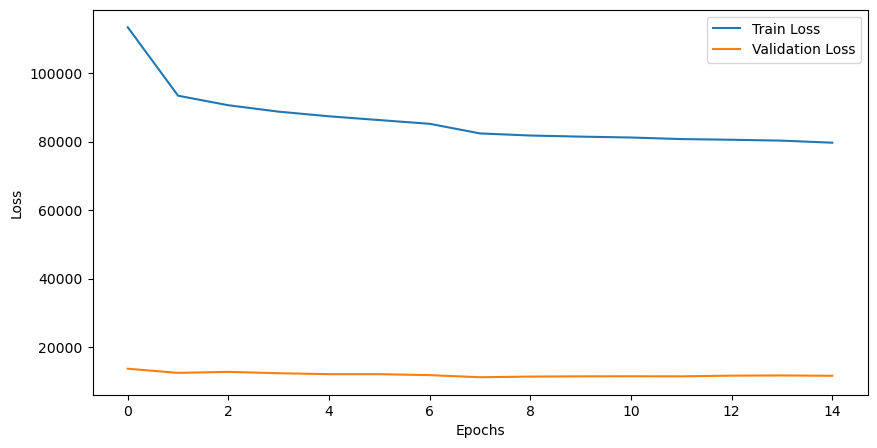

In [21]:
train_emotic(15, './models', opt, scheduler, [model_context, model_body, emotic_model], disc_loss, cont_loss_SL1)

# VI. Test model

Purpose: Functions to evaluate model performance.

Needed for performance assessment.

Summary: These functions calculate Mean Average Precision for categorical emotions, Mean Absolute Error for continuous dimensions (VAD), and optimal thresholds for emotion classification.

In [22]:
def test_scikit_ap(cat_preds, cat_labels):
    ap = np.zeros(26, dtype=np.float32)
    for i in range(26):
        ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
    print('ap', ap, ap.shape, ap.mean())
    return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
    vad = np.zeros(3, dtype=np.float32)
    for i in range(3):
        vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
    print('vad', vad, vad.shape, vad.mean())
    return vad.mean()


def get_thresholds(cat_preds, cat_labels):
    thresholds = np.zeros(26, dtype=np.float32)
    for i in range(26):
        p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
        for k in range(len(p)):
            if p[k] == r[k]:
                thresholds[i] = t[k]
                break
    np.save('./thresholds.npy', thresholds)
    return thresholds

print ('completed cell')

completed cell


Purpose: Evaluates the performance of each modality (image and text) separately on a dataset

Initializes arrays to store predictions and ground truth labels.

Moves models to the specified device (CPU/GPU) and sets them to evaluation mode.

Processes batches of data through the models without gradient calculation.

Collects separate predictions from image and text pathways.

Calculates performance metrics (AP and VAD) for each modality.

Returns performance metrics for comparison.

Summary: Tests and compares how well each modality performs independently at emotion recognition.

In [23]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, emotic_model = models
    cat_preds_img = np.zeros((num_images, 26))
    cat_preds_text = np.zeros((num_images, 26))
    cat_labels = np.zeros((num_images, 26))
    cont_preds_img = np.zeros((num_images, 3))
    cont_preds_text = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        indx = 0
        print('starting testing')
        for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            
            cat_out_img, cat_out_text, cont_out_img, cont_out_text, _, _ = emotic_model(pred_context, pred_body)

            cat_preds_img[indx : (indx + cat_out_img.shape[0]), :] = cat_out_img.cpu().numpy()
            cat_preds_text[indx : (indx + cat_out_text.shape[0]), :] = cat_out_text.cpu().numpy()
            cat_labels[indx : (indx + labels_cat.shape[0]), :] = labels_cat.cpu().numpy()
            cont_preds_img[indx : (indx + cont_out_img.shape[0]), :] = cont_out_img.cpu().numpy() * 10
            cont_preds_text[indx : (indx + cont_out_text.shape[0]), :] = cont_out_text.cpu().numpy() * 10
            cont_labels[indx : (indx + labels_cont.shape[0]), :] = labels_cont.cpu().numpy() * 10 
            indx = indx + cat_out_img.shape[0]

    print('completed testing')
    ap_mean_img = test_scikit_ap(cat_preds_img.T, cat_labels.T)
    ap_mean_text = test_scikit_ap(cat_preds_text.T, cat_labels.T)
    vad_mean_img = test_emotic_vad(cont_preds_img.T, cont_labels.T)
    vad_mean_text = test_emotic_vad(cont_preds_text.T, cont_labels.T)
    print(f"Image Modality - AP: {ap_mean_img:.4f}, VAD: {vad_mean_img:.4f}")
    print(f"Text Modality - AP: {ap_mean_text:.4f}, VAD: {vad_mean_text:.4f}")
    return ap_mean_img, ap_mean_text, vad_mean_img, vad_mean_text


Purpose: Evaluate and compare the performance of text and image modalities separately and combined.

Processes the dataset through the model, collecting predictions for text, image, and combined modalities.

Summary: Analyzes modality-specific performance using mean average precision, enabling comparison between text, image, and combined approaches.

In [24]:
def analyze_modality_performance(models, device, data_loader, num_images):
    """Analyze performance of each modality separately"""
    model_context, model_body, emotic_model = models
    
    # Storage for predictions and labels
    text_cat_preds = np.zeros((num_images, 26))
    img_cat_preds = np.zeros((num_images, 26))
    combined_cat_preds = np.zeros((num_images, 26))
    cat_labels = np.zeros((num_images, 26))
    
    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        
        indx = 0
        print('Analyzing modality performance')
        for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            
            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            
            # Get predictions from each modality
            combined_cat, _, _, _, text_cat, img_cat = emotic_model(
                pred_context, pred_body, return_embeddings=True
            )
            
            text_cat_preds[indx:(indx + text_cat.shape[0]), :] = text_cat.cpu().numpy()
            img_cat_preds[indx:(indx + img_cat.shape[0]), :] = img_cat.cpu().numpy()
            combined_cat_preds[indx:(indx + combined_cat.shape[0]), :] = combined_cat.cpu().numpy()
            cat_labels[indx:(indx + labels_cat.shape[0]), :] = labels_cat.cpu().numpy()
            
            indx = indx + text_cat.shape[0]
    
    # Transpose for evaluation
    text_cat_preds = text_cat_preds.transpose()
    img_cat_preds = img_cat_preds.transpose()
    combined_cat_preds = combined_cat_preds.transpose()
    cat_labels = cat_labels.transpose()
    
    # Calculate metrics
    print("Text modality performance:")
    text_ap = test_scikit_ap(text_cat_preds, cat_labels)
    
    print("Image modality performance:")
    img_ap = test_scikit_ap(img_cat_preds, cat_labels)
    
    print("Combined performance:")
    combined_ap = test_scikit_ap(combined_cat_preds, cat_labels)
    
    return {
        "text_ap": text_ap,
        "img_ap": img_ap,
        "combined_ap": combined_ap
    }


# VII. Embedding Space Analysis

Purpose: Extracts and collects embeddings from both modalities for analysis.

Core analysis functionality.

Summary: This function runs the model on a dataset, collecting raw feature embeddings from both the context (text) and body (image) pathways, along with predictions and ground truth labels.

In [38]:
def analyze_embedding_spaces(models, device, data_loader, num_samples=1000):
    """Extract embeddings from both modalities"""
    model_context, model_body, emotic_model = models
    
    # Storage for embeddings and predictions
    text_embeddings = []
    img_embeddings = []
    predictions_img = []
    predictions_text = []
    true_labels = []
    
    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        
        count = 0
        for images_context, images_body, labels_cat, _ in iter(data_loader):
            if count >= num_samples:
                break
                
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            
            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            
            cat_out_img, cat_out_text, cont_out_img, cont_out_text, img_emb, text_emb = emotic_model(pred_context, pred_body)
            
            text_embeddings.append(text_emb.cpu().numpy())
            img_embeddings.append(img_emb.cpu().numpy())
            predictions_img.append(cat_out_img.cpu().numpy())
            predictions_text.append(cat_out_text.cpu().numpy())
            true_labels.append(labels_cat.cpu().numpy())
            
            count += images_context.size(0)
    
    text_embeddings = np.vstack(text_embeddings)
    img_embeddings = np.vstack(img_embeddings)
    predictions_img = np.vstack(predictions_img)
    predictions_text = np.vstack(predictions_text)
    true_labels = np.vstack(true_labels)
    
    return text_embeddings, img_embeddings, predictions_img, predictions_text, true_labels


Purpose: Analyzes and compares the statistical properties of text and image embedding spaces to understand their characteristics and contributions to emotion recognition.

Calculates variance of embeddings to measure feature diversity in each modality

Computes cosine similarity between embeddings to measure clustering within each modality

Determines feature importance by correlating embedding dimensions with predictions

Identifies the top 10 most important features for each modality

Summary: This function quantifies key embedding space properties (variance, similarity, importance) to reveal how text and image modalities differ in their representation structure and predictive power.

In [39]:
def analyze_embedding_characteristics(text_emb, img_emb, pred_img, pred_text, labels):
    # Compute embedding variances
    text_variance = np.var(text_emb, axis=0).mean()
    img_variance = np.var(img_emb, axis=0).mean()
    
    # Compute average cosine similarities
    from sklearn.metrics.pairwise import cosine_similarity
    text_sim = cosine_similarity(text_emb[:500])  # Using subset for efficiency
    img_sim = cosine_similarity(img_emb[:500])
    text_avg_sim = (text_sim.sum() - text_sim.trace()) / (text_sim.size - text_sim.shape[0])
    img_avg_sim = (img_sim.sum() - img_sim.trace()) / (img_sim.size - img_sim.shape[0])
    
    # Compute feature importance
    text_importance = np.abs(np.corrcoef(text_emb.T, pred_text.T)[:text_emb.shape[1], text_emb.shape[1]:])
    img_importance = np.abs(np.corrcoef(img_emb.T, pred_img.T)[:img_emb.shape[1], img_emb.shape[1]:])
    
    text_top_features = np.argsort(text_importance.mean(axis=1))[-10:]
    img_top_features = np.argsort(img_importance.mean(axis=1))[-10:]
    
    return {
        "text_variance": text_variance,
        "img_variance": img_variance,
        "text_avg_sim": text_avg_sim,
        "img_avg_sim": img_avg_sim,
        "text_top_features": text_top_features,
        "img_top_features": img_top_features,
        "text_importance": text_importance,  # Add these two lines
        "img_importance": img_importance
    }


1. Load Models
    Purpose: Retrieves pre-trained neural network components from disk.
    Loads context encoder, body encoder, and emotion recognition model.
    Summary: Initializes the pre-trained models for analysis.

2. Evaluate Models
    Purpose: Measures performance of each modality separately.
    Calculates Average Precision and VAD metrics for text and image pathways.
    Summary: Quantifies how well each modality performs on emotion recognition.

3. Analyze Embeddings
    Purpose: Extracts feature representations from both modalities.
    Processes test data through models to collect embeddings and predictions.
    Summary: Gathers raw embedding data for further analysis.

4. Analyze Embedding Characteristics
    Purpose: Computes statistical properties of embedding spaces.
    Calculates variance, similarity, and feature importance metrics.
    Summary: Quantifies the structure and properties of each embedding space.

5. Print Results
    Purpose: Displays key embedding space metrics.
    Shows variance and similarity statistics for both modalities.
    Summary: Presents core embedding space characteristics for comparison.

6. Compare Modalities
    Purpose: Contrasts performance between text and image pathways.
    Displays AP and VAD metrics side by side.
    Summary: Enables direct performance comparison between modalities.

7. Visualize Embeddings with t-SNE
    Purpose: Creates 2D visualization of high-dimensional embeddings.
    Applies dimensionality reduction and plots embedding distributions.
    Summary: Provides visual insight into embedding space structure.

8. Visualize Top Features
    Purpose: Identifies most influential features in each modality.
    Creates bar charts of feature importance scores.
    Summary: Highlights which features contribute most to predictions.

9. Analyze Feature Diversity
    Purpose: Measures how specialized features are within each modality.
    Calculates standard deviation of feature importance.
    Summary: Determines whether features have specialized or uniform roles.

10. Analyze Modality Correlation
    Purpose: Measures relationship between modality representations.
    Calculates Pearson correlation between embedding averages.
    Summary: Quantifies how aligned the two modalities are.

11. Analyze Prediction Agreement
    Purpose: Determines how often modalities make the same predictions.
    Calculates percentage of matching predictions.
    Summary: Measures consistency between modality outputs.

12. Analyze Emotion-Specific Performance
    Purpose: Identifies which emotions are better predicted by which modality.
    Compares accuracy by emotion category across modalities.
    Summary: Reveals modality strengths for specific emotions.

13. Visualize Emotion Performance
    Purpose: Creates comprehensive view of emotion prediction performance.
    Generates bar chart comparing modalities across all emotions.
    Summary: Visualizes relative strengths of modalities by emotion.

14. Analyze Embedding Dimensionality
    Purpose: Determines intrinsic complexity of embedding spaces.
    Applies PCA and plots cumulative explained variance.
    Summary: Reveals how many dimensions are needed to capture information.

15. Final Summary
    Purpose: Consolidates key findings into concise takeaways.
    Presents six major conclusions about modality differences.
    Summary: Provides clear, actionable insights from the analysis.

starting testing
completed testing
ap [0.22992672 0.07191622 0.11697863 0.5563051  0.06064764 0.7229484
 0.09991238 0.20922633 0.14695902 0.16571411 0.01919859 0.83849543
 0.1543833  0.65733266 0.07399392 0.05216129 0.63155097 0.04503721
 0.19360532 0.37866113 0.14448176 0.05382148 0.12483713 0.08353334
 0.11818231 0.07453026] (26,) 0.2317054
ap [0.29244456 0.08239917 0.13048801 0.5712394  0.06021477 0.7406702
 0.11568888 0.24860072 0.15617846 0.16899095 0.02080594 0.84718734
 0.157898   0.6794826  0.10686483 0.05370023 0.64424294 0.07545836
 0.22148325 0.3969385  0.18596546 0.07686739 0.17891388 0.07951517
 0.13951848 0.08000686] (26,) 0.2504525
vad [0.9366006 1.0896914 0.9813668] (3,) 1.002553
vad [0.93068266 1.0502801  0.96991324] (3,) 0.98362535
Image Modality - AP: 0.2317, VAD: 1.0026
Text Modality - AP: 0.2505, VAD: 0.9836

Embedding Space Characteristics:
Text embedding variance: 0.0509
Image embedding variance: 0.0463
Text average similarity: 0.3088
Image average similarity: 0.

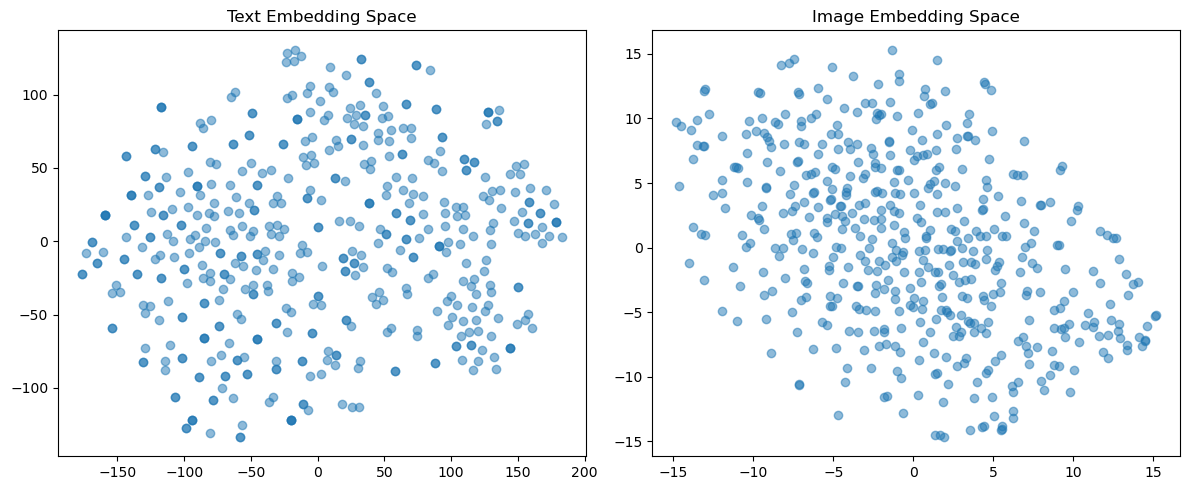

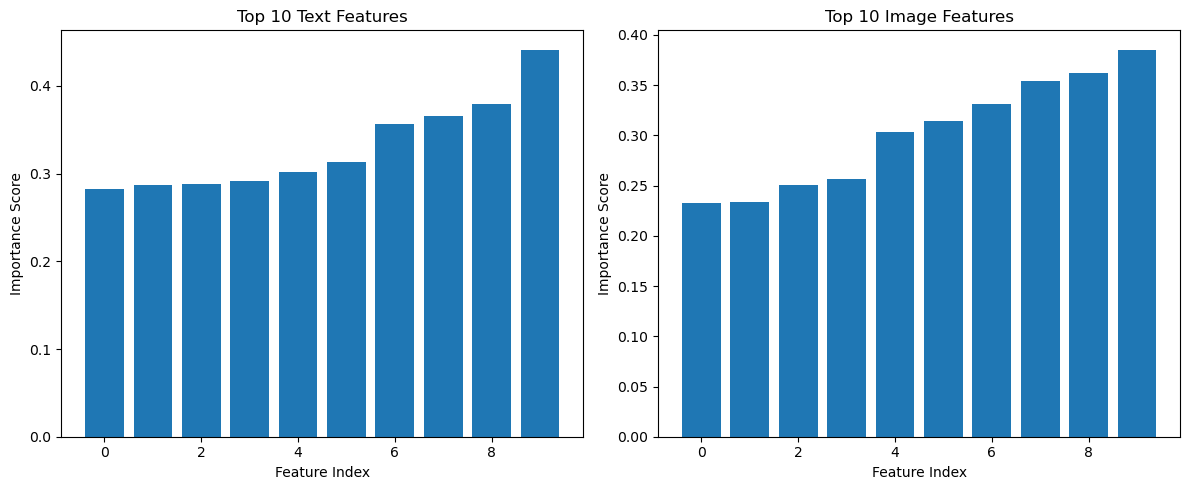


Text feature importance diversity: 0.0685
Image feature importance diversity: 0.0559
Text features show more diversity in importance, suggesting specialized roles.

Correlation between modalities: 0.3388
Agreement between modality predictions: 0.9804

Emotions better predicted by text modality:
Anticipation: Text=0.5483, Image=0.5325, Diff=0.0158
Excitement: Text=0.5207, Image=0.5148, Diff=0.0059
Affection: Text=0.8876, Image=0.8876, Diff=0.0000
Confidence: Text=0.5276, Image=0.5276, Diff=0.0000
Disconnection: Text=0.8521, Image=0.8521, Diff=0.0000

Emotions better predicted by image modality:
Suffering: Image=0.9665, Text=0.9576, Diff=0.0089
Happiness: Image=0.5325, Text=0.5207, Diff=0.0118
Sadness: Image=0.9576, Text=0.9448, Diff=0.0128
Anger: Image=0.9803, Text=0.9655, Diff=0.0148
Engagement: Image=0.6903, Text=0.6736, Diff=0.0168


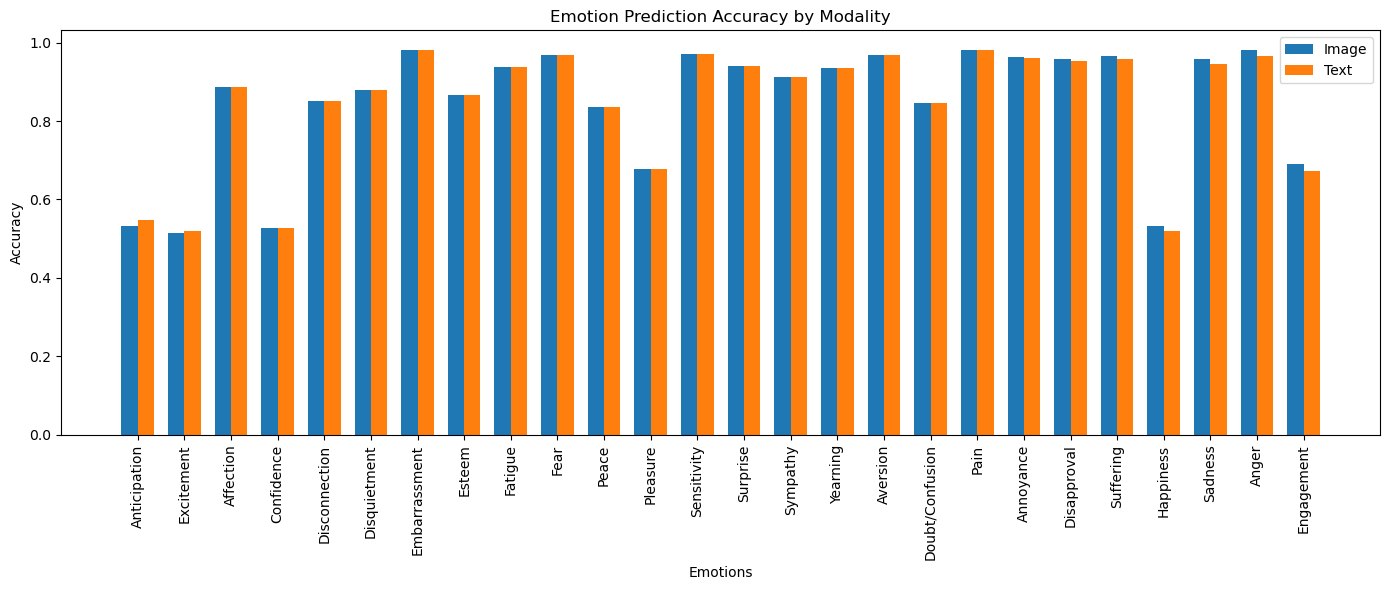

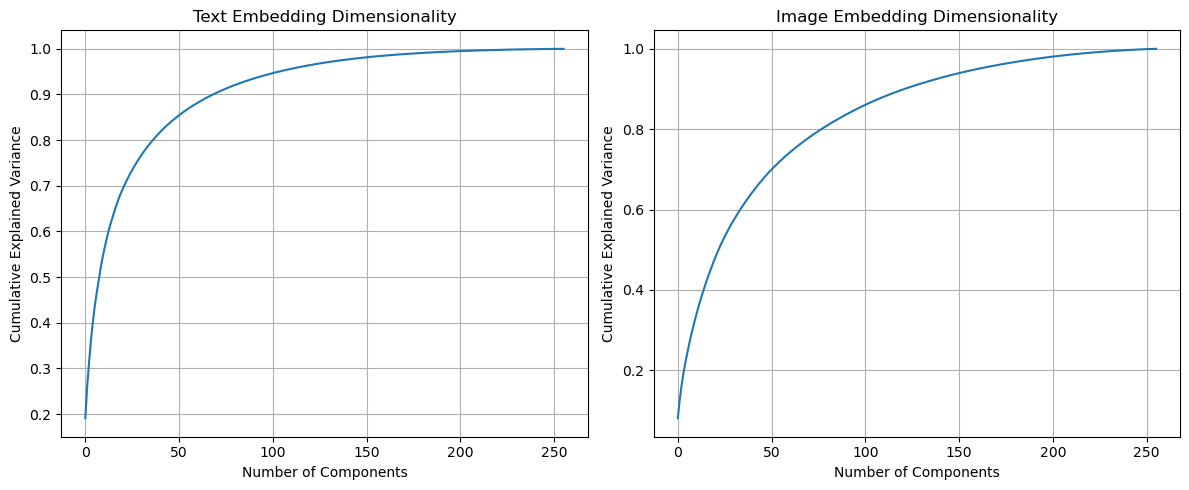


Effective dimensionality (95% variance):
Text embedding: 105 dimensions
Image embedding: 161 dimensions

Summary of Findings:
1. Performance: Text modality performs better overall
2. Variance: Text embeddings show higher variance
3. Similarity: Text embeddings show higher internal similarity
4. Dimensionality: Text embeddings have lower effective dimensionality
5. Feature Diversity: Text features show more diversity in importance
6. Modality Agreement: 98.04% agreement between modality predictions


In [40]:
# Main execution
if __name__ == "__main__":
    # Load models
    model_context = torch.load('./models/model_context1.pth', weights_only=False)
    model_body = torch.load('./models/model_body1.pth', weights_only=False)
    emotic_model = torch.load('./models/model_emotic1.pth', weights_only=False)
    
    # Evaluate models
    ap_img, ap_text, vad_img, vad_text = test_data([model_context, model_body, emotic_model], device, test_loader, len(test_dataset))
    
    # Analyze embeddings
    text_emb, img_emb, pred_img, pred_text, labels = analyze_embedding_spaces([model_context, model_body, emotic_model], device, test_loader)
    
    # Analyze embedding characteristics
    embedding_stats = analyze_embedding_characteristics(text_emb, img_emb, pred_img, pred_text, labels)
    
    # Print results
    print("\nEmbedding Space Characteristics:")
    print(f"Text embedding variance: {embedding_stats['text_variance']:.4f}")
    print(f"Image embedding variance: {embedding_stats['img_variance']:.4f}")
    print(f"Text average similarity: {embedding_stats['text_avg_sim']:.4f}")
    print(f"Image average similarity: {embedding_stats['img_avg_sim']:.4f}")
    
    # Compare modalities
    print("\nModality Comparison:")
    print(f"Text modality performance - AP: {ap_text:.4f}, VAD: {vad_text:.4f}")
    print(f"Image modality performance - AP: {ap_img:.4f}, VAD: {vad_img:.4f}")
    
    # Visualize embeddings with t-SNE
    from sklearn.manifold import TSNE
    
    # Reduce dimensionality for visualization
    tsne = TSNE(n_components=2, random_state=42)
    text_tsne = tsne.fit_transform(text_emb[:500])  # Using subset for speed
    
    tsne = TSNE(n_components=2, random_state=42)
    img_tsne = tsne.fit_transform(img_emb[:500])  # Using subset for speed
    
    # Plot embeddings
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(text_tsne[:, 0], text_tsne[:, 1], alpha=0.5)
    plt.title('Text Embedding Space')
    
    plt.subplot(1, 2, 2)
    plt.scatter(img_tsne[:, 0], img_tsne[:, 1], alpha=0.5)
    plt.title('Image Embedding Space')
    
    plt.tight_layout()
    plt.savefig('embedding_spaces.png')
    plt.show()
    
    # Visualize top features
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    top_text_importance = np.mean(embedding_stats['text_importance'], axis=1)[embedding_stats['text_top_features']]
    plt.bar(range(10), top_text_importance)
    plt.title('Top 10 Text Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance Score')
    
    plt.subplot(1, 2, 2)
    top_img_importance = np.mean(embedding_stats['img_importance'], axis=1)[embedding_stats['img_top_features']]
    plt.bar(range(10), top_img_importance)
    plt.title('Top 10 Image Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance Score')
    
    plt.tight_layout()
    plt.savefig('top_features.png')
    plt.show()
    
    # Analyze feature diversity
    text_feature_diversity = np.std(np.mean(embedding_stats['text_importance'], axis=1))
    img_feature_diversity = np.std(np.mean(embedding_stats['img_importance'], axis=1))
    print(f"\nText feature importance diversity: {text_feature_diversity:.4f}")
    print(f"Image feature importance diversity: {img_feature_diversity:.4f}")
    
    if text_feature_diversity > img_feature_diversity:
        print("Text features show more diversity in importance, suggesting specialized roles.")
    else:
        print("Image features show more diversity in importance, suggesting specialized roles.")
    
    # Analyze modality correlation
    from scipy.stats import pearsonr
    
    # Compute correlation between modalities
    modality_correlation = pearsonr(
        np.mean(text_emb, axis=1),
        np.mean(img_emb, axis=1)
    )[0]
    print(f"\nCorrelation between modalities: {modality_correlation:.4f}")
    
    # Analyze prediction agreement
    agreement = np.mean((pred_img > 0.5) == (pred_text > 0.5))
    print(f"Agreement between modality predictions: {agreement:.4f}")
    
    # Analyze which emotions are better predicted by which modality
    emotion_performance = []
    for i, emotion in enumerate(cat):
        img_acc = np.mean((pred_img[:, i] > 0.5) == (labels[:, i] > 0.5))
        text_acc = np.mean((pred_text[:, i] > 0.5) == (labels[:, i] > 0.5))
        emotion_performance.append((emotion, img_acc, text_acc))
    
    # Sort by difference between modalities
    emotion_performance.sort(key=lambda x: x[2] - x[1], reverse=True)
    
    print("\nEmotions better predicted by text modality:")
    for emotion, img_acc, text_acc in emotion_performance[:5]:
        print(f"{emotion}: Text={text_acc:.4f}, Image={img_acc:.4f}, Diff={text_acc-img_acc:.4f}")
    
    print("\nEmotions better predicted by image modality:")
    for emotion, img_acc, text_acc in emotion_performance[-5:]:
        print(f"{emotion}: Image={img_acc:.4f}, Text={text_acc:.4f}, Diff={img_acc-text_acc:.4f}")
    
    # Visualize emotion prediction performance by modality
    emotions = [e[0] for e in emotion_performance]
    img_acc = [e[1] for e in emotion_performance]
    text_acc = [e[2] for e in emotion_performance]
    
    plt.figure(figsize=(14, 6))
    x = np.arange(len(emotions))
    width = 0.35
    
    plt.bar(x - width/2, img_acc, width, label='Image')
    plt.bar(x + width/2, text_acc, width, label='Text')
    
    plt.xlabel('Emotions')
    plt.ylabel('Accuracy')
    plt.title('Emotion Prediction Accuracy by Modality')
    plt.xticks(x, emotions, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig('emotion_modality_performance.png')
    plt.show()
    
    # Compute and visualize embedding dimensionality
    from sklearn.decomposition import PCA
    
    # Compute PCA for both modalities
    pca_text = PCA().fit(text_emb)
    pca_img = PCA().fit(img_emb)
    
    # Plot explained variance
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.cumsum(pca_text.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Text Embedding Dimensionality')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(np.cumsum(pca_img.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Image Embedding Dimensionality')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('embedding_dimensionality.png')
    plt.show()
    
    # Find effective dimensionality (95% variance explained)
    text_dim = np.argmax(np.cumsum(pca_text.explained_variance_ratio_) >= 0.95) + 1
    img_dim = np.argmax(np.cumsum(pca_img.explained_variance_ratio_) >= 0.95) + 1
    
    print(f"\nEffective dimensionality (95% variance):")
    print(f"Text embedding: {text_dim} dimensions")
    print(f"Image embedding: {img_dim} dimensions")
    
    # Final summary
    print("\nSummary of Findings:")
    print(f"1. Performance: {'Text' if ap_text > ap_img else 'Image'} modality performs better overall")
    print(f"2. Variance: {'Text' if embedding_stats['text_variance'] > embedding_stats['img_variance'] else 'Image'} embeddings show higher variance")
    print(f"3. Similarity: {'Text' if embedding_stats['text_avg_sim'] > embedding_stats['img_avg_sim'] else 'Image'} embeddings show higher internal similarity")
    print(f"4. Dimensionality: {'Text' if text_dim < img_dim else 'Image'} embeddings have lower effective dimensionality")
    print(f"5. Feature Diversity: {'Text' if text_feature_diversity > img_feature_diversity else 'Image'} features show more diversity in importance")
    print(f"6. Modality Agreement: {agreement:.2%} agreement between modality predictions")
